In [ ]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pprint import pformat

from hloc import extract_features, match_features, pairs_from_covisibility
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization

# Pipeline for outdoor day-night visual localization

## Setup
Here we declare the paths to the dataset, the reconstruction and localization outputs, and we choose the feature extractor and the matcher. You only need to download the [Aachen Day-Night dataset](https://www.visuallocalization.net/datasets/) and put it in `datasets/aachen/`, or change the path.

In [ ]:
!wget https://data.ciirc.cvut.cz/public/projects/2020VisualLocalization/Aachen-Day-Night/aachen_v1_1.zip -P datasets
!unzip datasets/aachen_v1_1.zip -d datasets/aachen/

In [ ]:
dataset = Path('datasets/aachen/')  # change this if your dataset is somewhere else
images = dataset / 'images_upright/'

pairs = Path('pairs/aachen/')
sfm_pairs = pairs / 'pairs-db-covis20.txt'  # top 20 most covisible in SIFT model
loc_pairs = pairs / 'pairs-query-netvlad50.txt'  # top 50 retrieved by NetVLAD

outputs = Path('outputs/aachen/')  # where everything will be saved
reference_sfm = outputs / 'sfm_superpoint+superglue'  # the SfM model we will build
results = outputs / 'Aachen_hloc_superpoint+superglue_netvlad50.txt'  # the result file

In [ ]:
# list the standard configurations available
print(f'Configs for feature extractors:\n{pformat(extract_features.confs)}')
print(f'Configs for feature matchers:\n{pformat(match_features.confs)}')

In [ ]:
# pick one of the configurations for extraction and matching
# you can also simply write your own here!
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

## Extract local features for database and query images

In [ ]:
extract_features.main(feature_conf, images, outputs)

## Generate pairs for the SfM reconstruction
Instead of matching all database images exhaustively, we exploit the existing SIFT model to find which image pairs are the most covisible. We first convert the SIFT model from the NVM to the COLMAP format, and then do a covisiblity search, selecting the top 20 most covisibile neighbors for each image.

In [ ]:
colmap_from_nvm.main(
    dataset / '3D-models/aachen_cvpr2018_db.nvm',
    dataset / '3D-models/database_intrinsics.txt',
    dataset / 'aachen.db',
    outputs / 'sfm_sift')

pairs_from_covisibility.main(
    outputs / 'sfm_sift', sfm_pairs, num_matched=20)

## Match the database images

In [ ]:
match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

## Triangulate a new SfM model from the given poses
We triangulate the sparse 3D pointcloud given the matches and the reference poses. These are obtained from the NVM SIFT model by generating a new COLMAP model without 3D points.

In [ ]:
colmap_from_nvm.main(
    dataset / '3D-models/aachen_cvpr2018_db.nvm',
    dataset / '3D-models/database_intrinsics.txt',
    dataset / 'aachen.db',
    outputs / 'sfm_empty',
    skip_points=True)

triangulation.main(
    reference_sfm,
    outputs / 'sfm_empty',
    images,
    sfm_pairs,
    outputs / f"{feature_conf['output']}.h5",
    outputs / f"{feature_conf['output']}_{matcher_conf['output']}_{sfm_pairs.stem}.h5",
    colmap_path='colmap')  # change if COLMAP is not in your PATH

## Match the query images
Here we assume that the localization pairs are already computed using image retrieval (NetVLAD). To generate new pairs from your own global descriptors, have a look at `hloc/pairs_from_retrieval.py`. These pairs are also used for the localization - see below.

In [ ]:
match_features.main(matcher_conf, loc_pairs, feature_conf['output'], outputs)

## Localize!
Perform hierarchical localization using the precomputed retrieval and matches. The file `Aachen_hloc_superpoint+superglue_netvlad50.txt` will contain the estimated query poses. Have a look at `Aachen_hloc_superpoint+superglue_netvlad50.txt_logs.pkl` to analyze some statistics and find failure cases.

In [ ]:
localize_sfm.main(
    reference_sfm / 'model',
    dataset / 'queries/*_time_queries_with_intrinsics.txt',
    loc_pairs,
    outputs / f"{feature_conf['output']}.h5",
    outputs / f"{feature_conf['output']}_{matcher_conf['output']}_{loc_pairs.stem}.h5",
    results,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

## Visualizing the SfM model
We visualize some of the database images with their detected keypoints.

Color the keypoints by track length: red keypoints are observed many times, blue keypoints few.

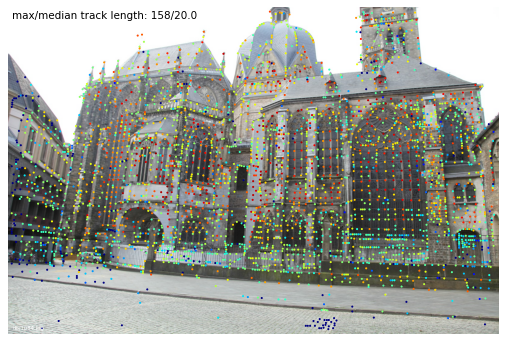

In [166]:
visualization.visualize_sfm_2d(reference_sfm / 'model', images, n=1, color_by='track_length')

Color the keypoints by visibility: blue if sucessfully triangulated, red if never matched.

In [ ]:
visualization.visualize_sfm_2d(reference_sfm / 'model', images, n=1, color_by='visibility')

Color the keypoints by triangulated depth: red keypoints are far away, blue keypoints are closer.

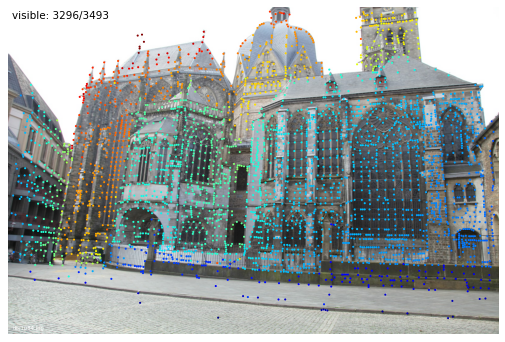

In [167]:
visualization.visualize_sfm_2d(reference_sfm / 'model', images, n=1, color_by='depth')

## Visualizing the localization
We parse the localization logs and for each query image plot matches and inliers with a few database images.

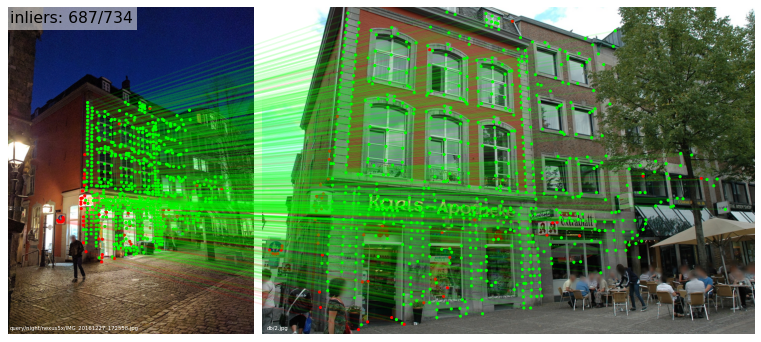

In [164]:
visualization.visualize_loc(
    results, images, reference_sfm / 'model', n=1, top_k_db=1, prefix='query/night', seed=2)